# Exploratory Analysis

In [18]:
import numpy as np
import hickle as hkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import sys
sys.path.append('../src/')
import ptype_prepare_data as pp

## t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique used to investigate or evaluate segmentation. Here we are using it as a way to understand separation in the training data.  

In [4]:
df = pd.read_csv('../data/ceo-plantations-train-v08.csv')

In [60]:
# create X and y for v08
X, y = pp.create_xy(['v08'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[],
                    verbose=True)

Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Training data includes 213 plots.
Class count {0.0: 25095, 1.0: 16653}


In [50]:
# understand label distribution
display(y.shape)
display(np.unique(y, return_counts=True))

(213, 14, 14)

(array([0., 1.]), array([25095, 16653]))

In [93]:
X_ = X[2, ...]
X_.shape

(14, 14, 78)

In [72]:
# X needs to be a 2d array
display(X.shape)
X_ = X[:1, ...]
X_re = X_.reshape(X_.shape[0]*X_.shape[1]*X_.shape[2], X_.shape[3])
display(X_re.shape)

(213, 14, 14, 78)

(196, 78)

In [74]:
# y needs to be a 1d array
display(y.shape)
y_ = y[:1, ...]
y_re = y_.reshape(y_.shape[0]*y_.shape[1]*y_.shape[2])
display(y_re.shape)

(213, 14, 14)

(196,)

In [75]:
# n components defines the num of target dims
tsne = TSNE(n_components=2, verbose=1, random_state=22)
z = tsne.fit_transform(X_re) 

/Users/jessica.ertel/opt/anaconda3/envs/plantations3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.001s...
[t-SNE] Computed neighbors for 196 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 0.874253
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.681446
[t-SNE] KL divergence after 800 iterations: 0.488665


In [79]:
z.shape, y_re.shape

((196, 2), (196,))

In [82]:
df = pd.DataFrame()
df["y"] = y_re
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3925490192.py:1: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x="comp-1",


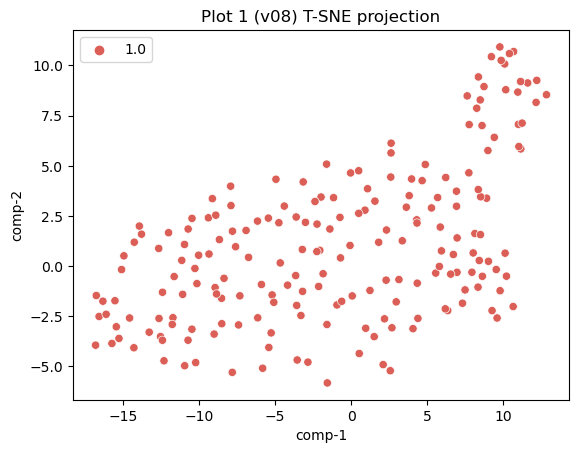

In [85]:
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Plot 1 (v08) T-SNE projection");

In [100]:
df = pd.DataFrame(columns=['y','comp-1', 'comp-2'])

for plot in range(10):
    
    X_ = X[plot, ...]
    X_re = X_.reshape(X_.shape[0]*X_.shape[1],X_.shape[2])
    y_ = y[plot, ...]
    y_re = y_.reshape(y_.shape[0]*y_.shape[1])
    
    tsne = TSNE(n_components=2, verbose=1, random_state=22)
    z = tsne.fit_transform(X_re) 
    
    for a, b, c in zip(y_re, z[:,0], z[:,1]):
        df = df.append({'y': a, 
                       'comp-1': b,
                       'comp-2': c},
                       ignore_index=True)

/Users/jessica.ertel/opt/anaconda3/envs/plantations3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.001s...
[t-SNE] Computed neighbors for 196 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 0.874253
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.681446
[t-SNE] KL divergence after 800 iterations: 0.488665
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.000s...


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

[t-SNE] Computed neighbors for 196 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 0.704927
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.858322
[t-SNE] KL divergence after 1000 iterations: 0.512044
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.000s...
[t-SNE] Computed neighbors for 196 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 1.165989


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.015022
[t-SNE] KL divergence after 900 iterations: 0.448950
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.000s...


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

[t-SNE] Computed neighbors for 196 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 1.057136
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.700020
[t-SNE] KL divergence after 900 iterations: 0.296229
[t-SNE] Computing 91 nearest neighbors...


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

[t-SNE] Indexed 196 samples in 0.001s...
[t-SNE] Computed neighbors for 196 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 0.731958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.429222
[t-SNE] KL divergence after 750 iterations: 0.459879
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.000s...


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

[t-SNE] Computed neighbors for 196 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 0.910300
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.547379
[t-SNE] KL divergence after 1000 iterations: 0.449091
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.000s...


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

[t-SNE] Computed neighbors for 196 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 1.105369
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.787033
[t-SNE] KL divergence after 1000 iterations: 0.430031
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.000s...


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

[t-SNE] Computed neighbors for 196 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 1.220608
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.001968
[t-SNE] KL divergence after 750 iterations: 0.337215
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.000s...


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

[t-SNE] Computed neighbors for 196 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 0.942254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.564419
[t-SNE] KL divergence after 1000 iterations: 0.574513
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.000s...


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

[t-SNE] Computed neighbors for 196 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 0.572196
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.571350
[t-SNE] KL divergence after 1000 iterations: 0.617077


/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/3334564497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': a,
/var/folders/1v/8qs7l7157sddx1_9

In [101]:
df

,y,comp-1,comp-2
0,1.0,10.687755,10.695891
1,1.0,12.212474,9.258592
2,1.0,11.160481,5.842154
3,1.0,-15.112713,-0.170907
4,1.0,-5.420203,-4.052346
...,...,...,...
1955,1.0,-3.669706,-6.758932
1956,1.0,-5.157403,-6.630228
1957,1.0,1.230861,-5.983315
1958,1.0,-4.567856,-5.288624


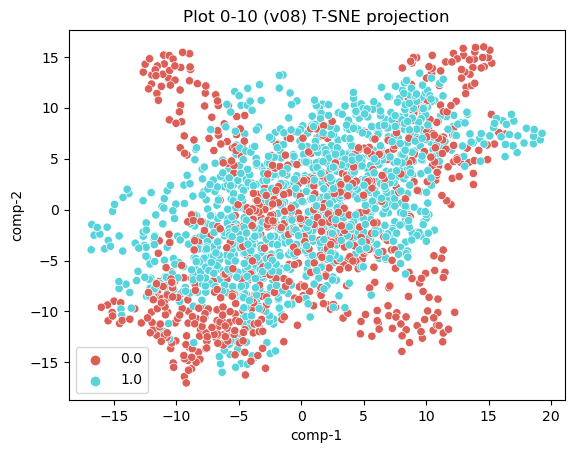

In [103]:
sns.scatterplot(x="comp-1", 
                y="comp-2", 
                hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Plot 0-10 (v08) T-SNE projection");

In [98]:
df = pd.DataFrame(columns=['y','comp-1', 'comp-2'])
a = [1.0, 1.0, 1.0, 1.0]
b = [10.687755, 12.212474, 11.160481, -15.112713]
c = [10.695891, 9.258592, 5.8421535, -0.17090698]
for d, e, f in zip(a, b, c):
    df = df.append({'y': d, 
                   'comp-1': e,
                   'comp-2': f},
                   ignore_index=True)

/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/4246384139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': d,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/4246384139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': d,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/4246384139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': d,
/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_61635/4246384139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'y': d,
